In [1]:
import pandas as pd
data = pd.read_csv('data/a943287.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64084 entries, 0 to 64083
Data columns (total 10 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   _unit_id                                                          64084 non-null  int64  
 1   _golden                                                           64084 non-null  bool   
 2   _unit_state                                                       64084 non-null  object 
 3   _trusted_judgments                                                64084 non-null  int64  
 4   _last_judgment_at                                                 63984 non-null  object 
 5   please_select_the_gender_of_the_person_in_the_picture             64084 non-null  object 
 6   please_select_the_gender_of_the_person_in_the_picture:confidence  64084 non-null  float64
 7   image_url                      

In [2]:
vc = data['please_select_the_gender_of_the_person_in_the_picture'].value_counts()
print(vc)

please_select_the_gender_of_the_person_in_the_picture
male      47595
unsure     9122
female     7367
Name: count, dtype: int64


In [3]:
data_male = data[data['please_select_the_gender_of_the_person_in_the_picture'] == 'male']
data_female = data[data['please_select_the_gender_of_the_person_in_the_picture'] == 'female']
final_data = pd.concat([data_male[:1000], data_female[:1000]], axis=0).reset_index(drop=True)

print(final_data.shape)

(2000, 10)


In [4]:
from skimage import io

x = []
y = []
for i in range(final_data.shape[0]):
    try:
        image = io.imread(final_data.loc[i]['image_url']) # url로부터 이미지 읽어올림
        if (image.shape == (300, 300, 3)):
            x.append(image)
            y.append(final_data.loc[i]['please_select_the_gender_of_the_person_in_the_picture']) # 성별을 함께 읽어올림
    except:
        continue

In [18]:
from skimage.transform import resize
import numpy as np

x2 = []
y2 = []
for i in range(len(x)):
    img2 = resize(x[i], (50, 50), anti_aliasing=True, mode='reflect')
    x2.append(img2)
    img_label = np.where(y[i] == 'male', 1, 0) # male이라는 조건이 맞으면 1로, 그렇지 않으면(=female) 0으로 놓음
    y2.append(img_label)

x2 = np.array(x2)
print(x2.shape)

(1709, 50, 50, 3)


In [19]:
y1 = np.array(y2)
x1 = x2.astype('float32') / 255.

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42, stratify=y)

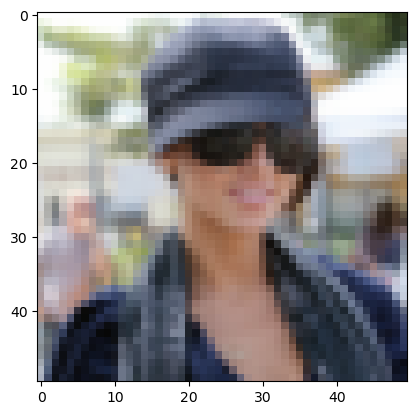

In [23]:
import matplotlib.pyplot as plt
plt.imshow(x_train[1] * 255)  # (0, 1) 범위를 다시 (0, 255)로 변환
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.initializers import he_normal

model = Sequential()
model.add(
    Conv2D(32, (3, 3), activation='relu', input_shape=[50, 50, 3], kernel_initializer=he_normal())
)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal())
)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal())
)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=he_normal())
)
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
result = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=30,
    validation_data=(x_test, y_test)
)
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

Epoch 1/30


2024-10-15 06:45:10.006538: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


43/43 [==============================] - 1s 17ms/step - loss: 0.6933 - accuracy: 0.5223 - val_loss: 0.6921 - val_accuracy: 0.5205
Epoch 2/30
43/43 [==============================] - 1s 16ms/step - loss: 0.6917 - accuracy: 0.5216 - val_loss: 0.6899 - val_accuracy: 0.5322
Epoch 3/30
43/43 [==============================] - 1s 15ms/step - loss: 0.6921 - accuracy: 0.5208 - val_loss: 0.6919 - val_accuracy: 0.5205
Epoch 4/30
43/43 [==============================] - 1s 16ms/step - loss: 0.6896 - accuracy: 0.5260 - val_loss: 0.6872 - val_accuracy: 0.5497
Epoch 5/30
43/43 [==============================] - 1s 16ms/step - loss: 0.6663 - accuracy: 0.5903 - val_loss: 0.6811 - val_accuracy: 0.5936
Epoch 6/30
43/43 [==============================] - 1s 17ms/step - loss: 0.6534 - accuracy: 0.5947 - val_loss: 0.6678 - val_accuracy: 0.5789
Epoch 7/30
43/43 [==============================] - 1s 16ms/step - loss: 0.6391 - accuracy: 0.6101 - val_loss: 0.6693 - val_accuracy: 0.5877
Epoch 8/30
43/43 [======

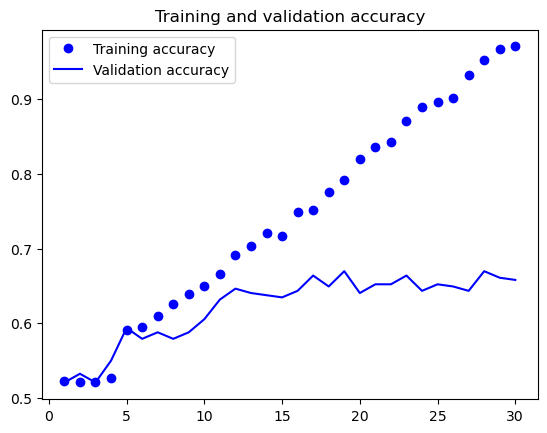

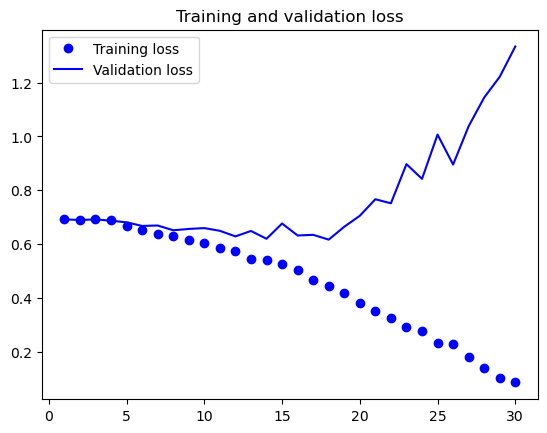

In [24]:
import matplotlib.pyplot as plt

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']
epochs = range(1, len(acc)+1) # x축에 들어갈 epoch의 증가정보

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Transfer Learning 1

In [25]:
from tensorflow.keras.applications import VGG16
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(300, 300, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [26]:
from tensorflow.keras.applications.vgg16 import preprocess_input

x5 = []
y5 = []

for i in range(len(x)):
    img = x[i]
    img = preprocess_input(img.reshape(1, 300, 300, 3))
    img_new = vgg16.predict(img)
    x5.append(img_new)
    img_label = np.where(y[i] == 'male', 1, 0)
    y5.append(img_label)

1/1 [==============================] - 0s 76ms/step


In [27]:
x5 = np.array(x5)
print(x5.shape)

(1709, 1, 9, 9, 512)


In [28]:
x5 = x5.reshape(x5.shape[0], x5.shape[2], x5.shape[3], x5.shape[4])
y5 = np.array(y5)
print(y5.shape)

(1709,)


In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x5, y5, test_size=0.2, random_state=42, stratify=y5)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(
    Conv2D(512, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 512)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                      

In [31]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(
    x_train/np.max(x_train), y_train,
    batch_size=32,
    epochs=30,
    validation_data=(x_test/np.max(x_train), y_test)
)

Epoch 1/30
43/43 [==============================] - 1s 28ms/step - loss: 0.3609 - accuracy: 0.8427 - val_loss: 0.2834 - val_accuracy: 0.8860
Epoch 2/30
43/43 [==============================] - 1s 27ms/step - loss: 0.1183 - accuracy: 0.9576 - val_loss: 0.3295 - val_accuracy: 0.8860
Epoch 3/30
43/43 [==============================] - 1s 28ms/step - loss: 0.0421 - accuracy: 0.9890 - val_loss: 0.3231 - val_accuracy: 0.9006
Epoch 4/30
43/43 [==============================] - 1s 26ms/step - loss: 0.0144 - accuracy: 0.9963 - val_loss: 0.3947 - val_accuracy: 0.8860
Epoch 5/30
43/43 [==============================] - 1s 26ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.4347 - val_accuracy: 0.9006
Epoch 6/30
43/43 [==============================] - 1s 26ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4591 - val_accuracy: 0.8889
Epoch 7/30
43/43 [==============================] - 1s 27ms/step - loss: 8.7903e-04 - accuracy: 1.0000 - val_loss: 0.4795 - val_accuracy: 0.8860
Epoch 8/3

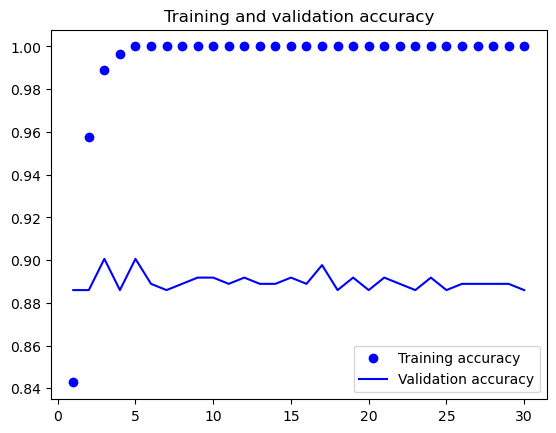

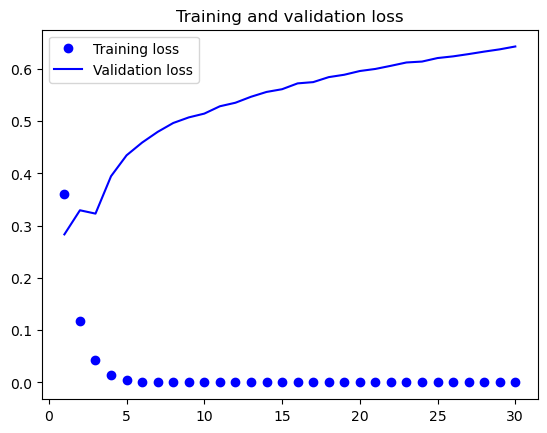

In [32]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()